<a href="https://colab.research.google.com/github/entc-17-fyp-20/CM_Data_Visualizing/blob/samal/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load the dataset

In [ ]:
pip install pycaret

     |████████████████████████████████| 264 kB 3.1 MB/s 
     |████████████████████████████████| 248 kB 39.2 MB/s 
     |████████████████████████████████| 1.7 MB 22.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 8.6 MB/s 
     |████████████████████████████████| 167 kB 68.2 MB/s 
     |████████████████████████████████| 14.6 MB 84 kB/s 
     |████████████████████████████████| 111 kB 73.3 MB/s 
     |████████████████████████████████| 6.8 MB 41.3 MB/s 
     |████████████████████████████████| 1.3 MB 69.1 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 51.5 MB/s 
     |████████████████████████████████| 2.0 MB 44.1 MB/s 
     |████████████████████████████████| 10.1 MB 46.3 MB/s 
     |████████████████████████████████| 675 kB 40.0 MB/s 
     |██████████████████

### Dimension reduction upto 10 variables

Original dataset contains 23 features. Following features has a correlation coefficient greater than 0.8 ( highly correlated) 

* Voltage Phase R                  
* Voltage Phase S                   
* Voltage Phase T  


---


* Current Phase R                    
* Current Phase S                  
* Current Phase T 


---


* Gearbox oil Temperature            
* Gearbox Bearing Temperature       
* Generator Winding Temperature R    
* Generator Winding Temperature S    
* Generator Winding Temperature T 
* Main bearing Temperature         
* Generator Bearing Temperature DE   
* Generator Bearing Temperature NDE  

---

Those features averaged to form only 3 features



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv?token=ANECSWYTSJHLNER56T5JDR3BCLBDK' #V08 June 10 sec data.csv
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv?token=ANECSW37NCJ7TMWXNPKFHM3BCLBK2' #V13 June 10 sec data.csv
df5 = pd.read_csv(url3)

#average temperature data
df5["Gearbox & Bearing temp"]  = (df5["Gearbox Bearing Temperature"] + df5["Gearbox oil Temperature"]+ df5["Generator Winding Temperature R"]+df5["Generator Winding Temperature S"]+df5["Generator Winding Temperature T"]+df5["Main bearing Temperature"] + df5["Generator Bearing Temperature DE"]+ df5["Generator Bearing Temperature NDE"])/8

#drop less important features
df5.drop(["Reactive Power kVAR", "Frequency Hz","Voltage Phase R","Voltage Phase S","Voltage Phase T","Current Phase R","Current Phase S","Current Phase T","Gearbox Bearing Temperature","Gearbox oil Temperature","Generator Winding Temperature R","Generator Winding Temperature S","Generator Winding Temperature T","Main bearing Temperature","Generator Bearing Temperature DE","Generator Bearing Temperature NDE",'Hydraulic unit Pressure in bar'], axis='columns', inplace=True)
#copy of original dataframe
df5_copy = df5.copy()
df5.describe()

#convert time to standard format
df5['Date & Time'] = pd.to_datetime(df5['Date & Time'], format="%d/%m/%Y %H:%M:%S")
df5.set_index('Date & Time', inplace = True)

#Downsample data
df5= df5.resample('10min').mean().reset_index()

#drop missing data
df5=df5.head(3100)
df5_new = df5[['Date & Time']]


### Outlier detection using iforest model and replcement by moving average

In [ ]:
column_list = [ 'Nacelle Temperature', 'Ambient Temperature','Hydraulic oil Temperature','Gearbox & Bearing temp']
for column_name in column_list:


  df5_sub = df5[['Date & Time',column_name]]
  df5_sub['MA48'] = df5_sub[column_name].rolling(16,center=True,min_periods=1).mean()

  from pycaret.anomaly import *
  s = setup(df5_sub, session_id = 123)

  iforest = create_model('iforest', fraction = 0.01)
  iforest_results = assign_model(iforest)

  df5_new[column_name+' new'] = iforest_results['MA48'].values*iforest_results['Anomaly'].values+iforest_results[column_name].values*(1-iforest_results['Anomaly'].values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ModuleNotFoundError: ignored

In [ ]:
for column_name in column_list:
  fig = px.line(df5, x="Date & Time" , y=column_name) 
  fig.show()

In [ ]:
from scipy.interpolate import interp1d

x = np.linspace(-5, 28, num=34, endpoint=True)
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 75, 150, 240, 362.5, 512.5, 670, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800])
f = interp1d(x, y, kind='cubic') # creating function


In [ ]:
error_margin = 0.45 #@param {type:"slider", min:0.1, max:0.6, step:0.05}

def fil(x):
  return int(f(x))

def compare(x):
  actual = x["Active Power kW"]
  calculated = x["Power_cal"]

  if calculated == 0:
    error = abs(actual-calculated)/0.001
    if error>error_margin:
      return calculated
    return actual

  error = abs(actual-calculated)/calculated
  if error>error_margin:
    return calculated
  return actual

def addcol(x):
  actual = x["Active Power kW"]
  calculated = x["Power_cal"]

  if calculated == 0:
    error = abs(actual-calculated)/0.001
    if error>error_margin:
      return "replaced"
    return "actual"

  error = abs(actual-calculated)/calculated
  if error>error_margin:
    return "replaced"
  return "actual"

In [ ]:
df5["Power_cal"] = df5["Wind Speed m/s"].apply(fil) # calculating power from wind speed
df5["Active Power"] = df5.apply(compare, axis=1) # Replacing outliers with calculated power
df5["Power_cate"] = df5.apply(addcol, axis=1) # Addting outlier/not outlier column

In [ ]:
df5.drop(['Active Power kW','Generator RPM','Power_cal','Power_cate'], axis='columns', inplace=True)

In [ ]:
df_to_kmeans = df5[['Ambient Temperature','Gearbox & Bearing temp','Active Power','Wind Speed m/s','Nacelle Temperature']]

In [ ]:
fig = px.scatter(df5, x='Ambient Temperature' , y='Gearbox & Bearing temp') 
fig.show()

### iforest model for normal/anomaly data clustering

In [ ]:
from pycaret.anomaly import *
s = setup(df_to_kmeans, session_id = 123)

iforest = create_model('iforest', fraction = 0.05)
iforest_results = assign_model(iforest)


In [ ]:
iforest_results

,Ambient Temperature,Gearbox & Bearing temp,Active Power,Wind Speed m/s,Nacelle Temperature,Anomaly,Anomaly_Score
0,30.746667,83.150208,475.936667,8.900000,31.150000,0,-0.090581
1,30.790000,82.710208,447.813333,8.708333,31.220000,0,-0.078730
2,30.683333,83.413958,485.601667,8.853333,30.775000,0,-0.126074
3,30.356667,82.530833,459.966667,8.731667,30.446667,0,-0.141555
4,30.328333,82.909792,497.221667,9.021667,30.206667,0,-0.149357
...,...,...,...,...,...,...,...
3095,31.576667,92.653333,726.665000,10.346667,30.478333,0,-0.132362
3096,31.703333,92.449792,696.938333,10.041667,30.590000,0,-0.134559
3097,31.491667,93.257292,739.048333,10.790000,30.411667,0,-0.124037
3098,31.663333,93.771875,742.513333,10.756667,30.741667,0,-0.104979


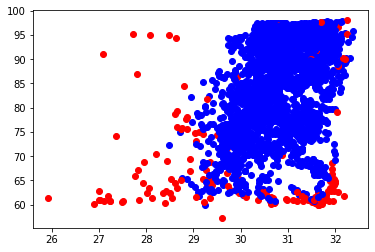

In [ ]:
col=[]
for i in iforest_results['Anomaly']:
  if i==1:
        col.append('r')
  else:
    col.append('b')


for i in range(df_to_kmeans.shape[0]):
    plt.scatter(df_to_kmeans.iloc[i][0],df_to_kmeans.iloc[i][1],c=col[i])

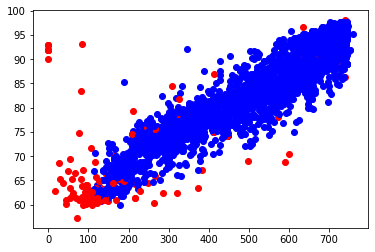

In [ ]:
col=[]
for i in iforest_results['Anomaly']:
  if i==1:
        col.append('r')
  else:
    col.append('b')


for i in range(df_to_kmeans.shape[0]):
    plt.scatter(df_to_kmeans.iloc[i][2],df_to_kmeans.iloc[i][1],c=col[i])

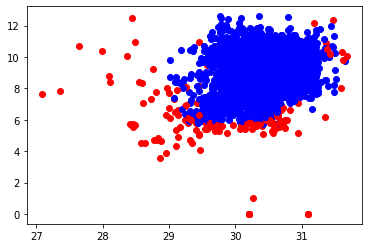

In [ ]:
col=[]
for i in iforest_results['Anomaly']:
  if i==1:
        col.append('r')
  else:
    col.append('b')


for i in range(df_to_kmeans.shape[0]):
    plt.scatter(df_to_kmeans.iloc[i][4],df_to_kmeans.iloc[i][3],c=col[i])

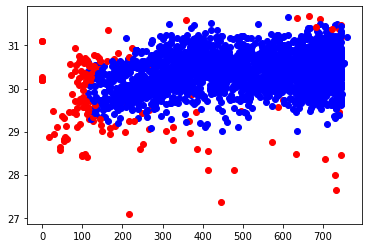

In [ ]:
col=[]
for i in iforest_results['Anomaly']:
  if i==1:
        col.append('r')
  else:
    col.append('b')


for i in range(df_to_kmeans.shape[0]):
    plt.scatter(df_to_kmeans.iloc[i][2],df_to_kmeans.iloc[i][4],c=col[i])

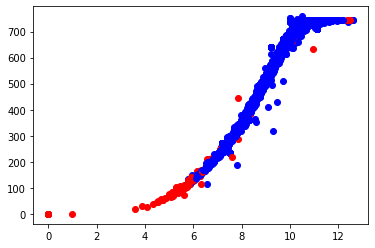

In [ ]:
col=[]
for i in iforest_results['Anomaly']:
  if i==1:
        col.append('r')
  else:
    col.append('b')


for i in range(df_to_kmeans.shape[0]):
    plt.scatter(df_to_kmeans.iloc[i][3],df_to_kmeans.iloc[i][2],c=col[i])

### K-means Clusturing

In [ ]:

data = np.array(df_to_kmeans)


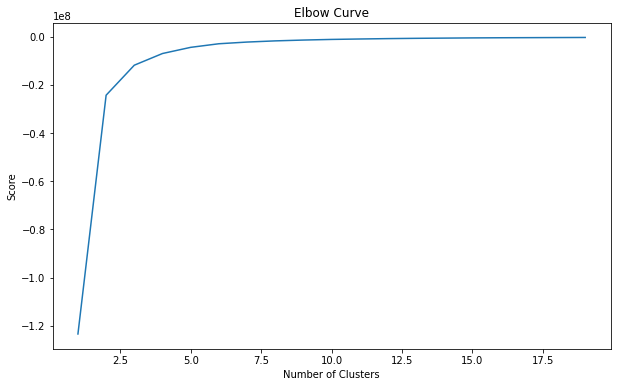

In [ ]:
from sklearn.cluster import KMeans
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(df_to_kmeans) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [ ]:
from sklearn.preprocessing import StandardScaler
X = df_to_kmeans.values
X_std = StandardScaler().fit_transform(X)

In [ ]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [ ]:
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)

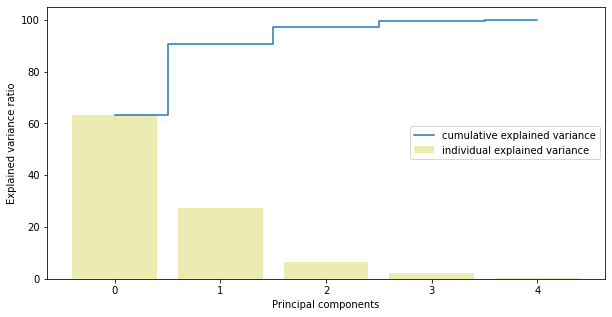

In [ ]:
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'y')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [ ]:
def getDistanceByPoint(data, model):
   distance = pd.Series()
   for i in range(0,len(data)):
       Xa = np.array(data.loc[i])
       Xb = model.cluster_centers_[model.labels_[i]-1]
       distance.at[i]=np.linalg.norm(Xa-Xb)
   return distance

In [ ]:
outliers_fraction = 0.1
distance = getDistanceByPoint(df_to_kmeans, kmeans[4])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
df_to_kmeans['anomaly1'] = (distance >= threshold).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



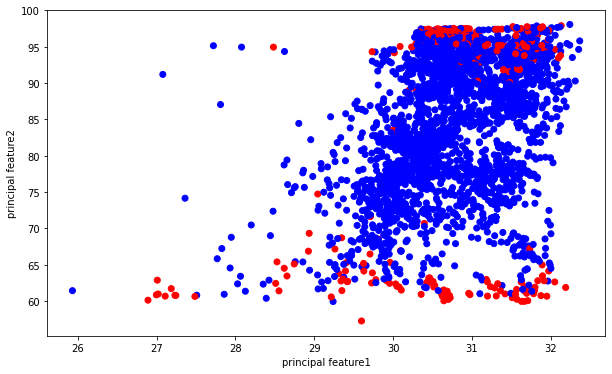

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_to_kmeans['Ambient Temperature'], df_to_kmeans['Gearbox & Bearing temp'], c=df_to_kmeans["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

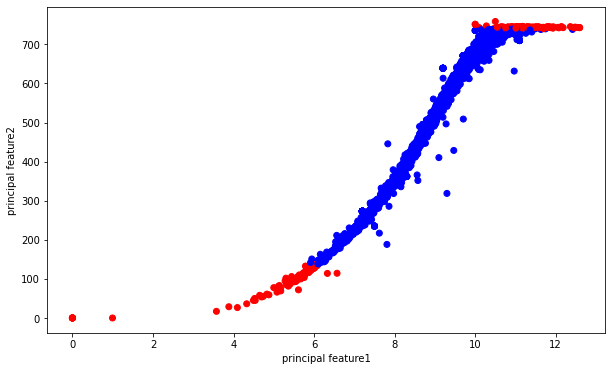

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_to_kmeans['Wind Speed m/s'], df_to_kmeans['Active Power'], c=df_to_kmeans["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

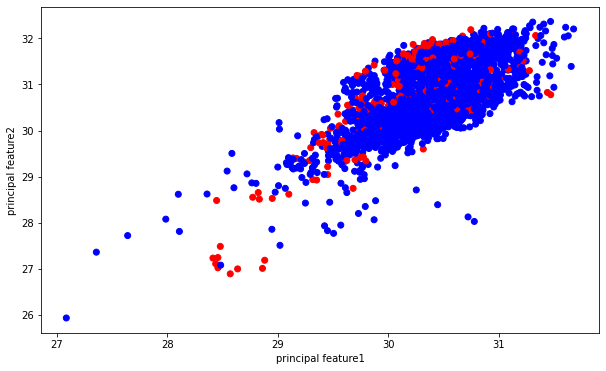

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_to_kmeans['Nacelle Temperature'], df_to_kmeans['Ambient Temperature'], c=df_to_kmeans["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

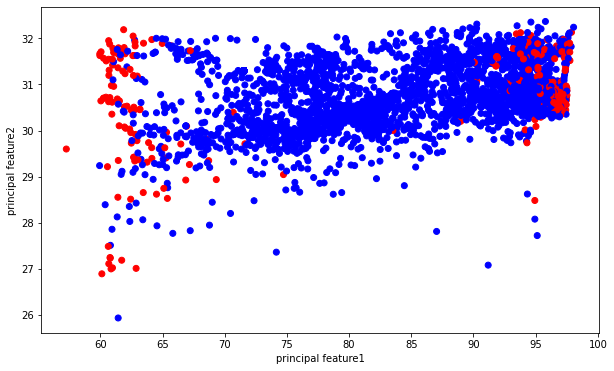

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_to_kmeans['Gearbox & Bearing temp'], df_to_kmeans['Ambient Temperature'], c=df_to_kmeans["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [ ]:
df_to_kmeans['date_time'] = df5['Date & Time']

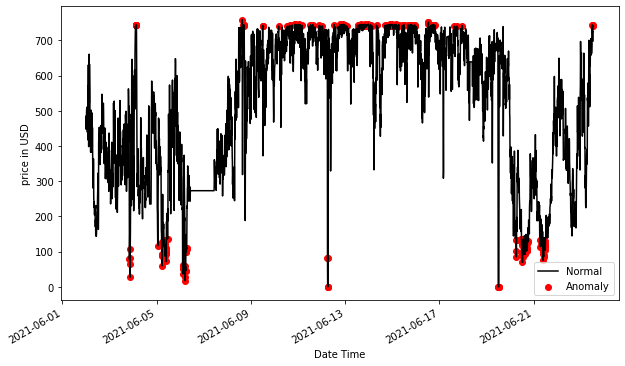

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
a = df_to_kmeans.loc[df_to_kmeans['anomaly1'] == 1, ['date_time', 'Active Power']] #anomaly
ax.plot(df_to_kmeans['date_time'], df_to_kmeans['Active Power'], color='k',label='Normal')
ax.scatter(a['date_time'],a['Active Power'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()
